In [48]:
%cd '/home/urbanaq/cams_downscaling'

/home/urbanaq/cams_downscaling


In [49]:
from cams_downscaling.utils import read_config

config = read_config('/home/urbanaq/cams_downscaling/config')

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

In [51]:
variable = 'NO2'
region = 'iberia'

bbox = config['regions'][region]['bbox']

bbox

{'min_lat': 35.7, 'min_lon': -9.9, 'max_lat': 44.1, 'max_lon': 4.5}

# 0. Preprocesament

1. Temporal resampling datasets 
2. Regriding datasets (Bilinear interpolation)
3. Define Regions of Interest (ROIs) 
4. Generate station permutations for each ROI(X-1/1) 
5. Interpolate stations (X-1) (Nearest neighbours + Kriging) 
6. Add geographical proximity covariates 
7. Add interpolation covariates 

# 1. CAMS data

In [52]:
from cams_downscaling.readers.cams import load_cams

cams_path = config['paths']['cams']
cams_path = os.path.join(cams_path, variable.lower(), region)

#dates = pd.date_range('2022-01-01T00:00:00', '2023-12-31T23:00:00', freq='h')
dates = pd.date_range('2022-01-01T00:00:00', '2022-01-01T23:00:00', freq='h')
cams = load_cams(cams_path, dates=dates)

cams

TimeseriesGridData(
    > Axes:
        - date: 24 elements
        - lat: 84 elements
        - lon: 144 elements
    > Data:
        - no2: (24, 84, 144)
    > Memory: 1.11 MB
)

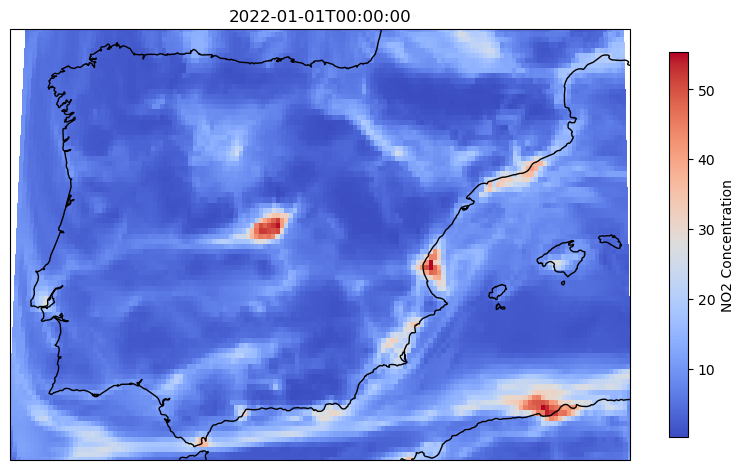

In [53]:
data = cams[pd.to_datetime('2022-01-01T00:00:00'), :, :].values['no2']

# Define the extent
extent = (cams.lon.min(), cams.lon.max(), cams.lat.min(), cams.lat.max())

# Create a meshgrid for the coordinates
lon, lat = np.meshgrid(cams.lon, cams.lat)

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Using pcolormesh for accurate pixel plotting
im = ax.pcolormesh(lon, lat, data.squeeze(), cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('NO2 Concentration')

# Set the title
plt.title('2022-01-01T00:00:00')

# Show the plot
plt.show()

## 1.1. Temporal resampling

CAMS is already in hourly format, so no need to resample

## 1.2. Regridding datasets

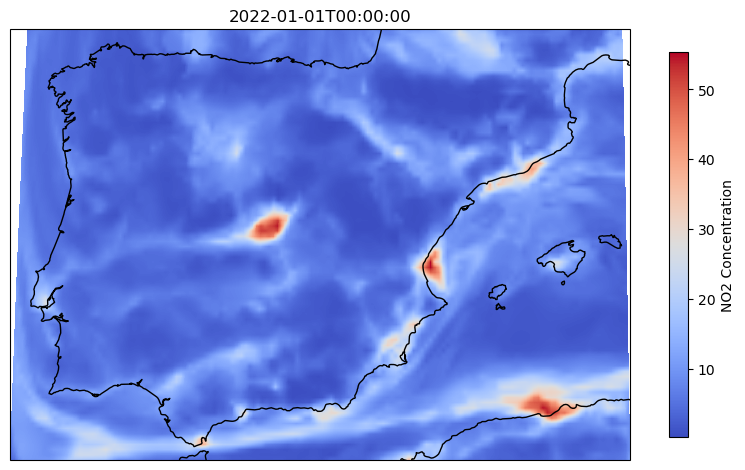

In [54]:
new_resolution = 0.01

new_lat = np.arange(cams.lat.min(), cams.lat.max(), new_resolution)
new_lon = np.arange(cams.lon.min(), cams.lon.max(), new_resolution)

new_cams = cams.interpolate(lat=new_lat, lon=new_lon)
new_data = new_cams[pd.to_datetime('2022-01-01T00:00:00'), :, :].values['no2']

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Using pcolormesh for accurate pixel plotting
im = ax.pcolormesh(new_lon, new_lat, new_data.squeeze(), cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('NO2 Concentration')

# Set the title
plt.title('2022-01-01T00:00:00')

# Show the plot
plt.show()

In [55]:
new_cams

TimeseriesGridData(
    > Axes:
        - date: 24 elements
        - lat: 830 elements
        - lon: 1431 elements
    > Data:
        - no2: (24, 830, 1431)
    > Memory: 217.48 MB
)

In [56]:
# Finished, delete the cams to free up memory
del cams
del new_cams

# 2. EEA Stations

In [57]:
import pandas as pd

stations = pd.read_csv(
    config['paths']['stations'] + '/stations.csv',
    usecols=["Air Quality Station EoI Code", "Longitude", "Latitude", "Country"],
    index_col="Air Quality Station EoI Code")

stations = stations[
    (stations["Longitude"].between(bbox["min_lon"], bbox["max_lon"])) & 
    (stations["Latitude"].between(bbox["min_lat"], bbox["max_lat"]))]

stations.index.name = 'station'

stations = stations.drop_duplicates()

stations = stations[stations["Country"].isin(['Spain', 'Portugal', 'Andorra'])].drop(columns=["Country"])

stations

,Longitude,Latitude
station,,
AD0942A,1.5391,42.5097
AD0944A,1.5653,42.5169
AD0945A,1.7170,42.5349
ES1044A,-0.8711,41.6703
ES1047A,-0.9161,41.6514
...,...,...
PT01100,-6.8872,41.5719
PT05007,-7.9267,37.0150
PT05008,-8.2497,37.0917


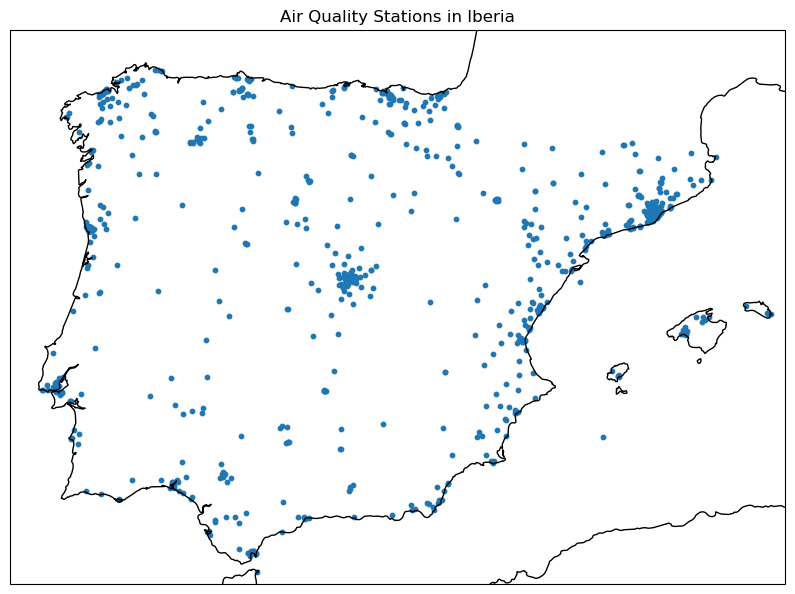

In [58]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
ax.scatter(stations.Longitude, stations.Latitude, transform=ccrs.PlateCarree(), s=10)
plt.title("Air Quality Stations in Iberia")
plt.show()

In [59]:
spain = pd.read_csv(config['paths']['stations'] + '2022/ES.csv', usecols=['time', 'station', variable], index_col=['time', 'station'], parse_dates=['time'])
portugal = pd.read_csv(config['paths']['stations'] + '2022/PT.csv', usecols=['time', 'station', variable], index_col=['time', 'station'], parse_dates=['time'])
andorra = pd.read_csv(config['paths']['stations'] + '2022/AD.csv', usecols=['time', 'station', variable], index_col=['time', 'station'], parse_dates=['time'])
observations = pd.concat([spain, portugal, andorra])

# Create a dataframe with all combinations of timestamps and stations
all_combinations = pd.MultiIndex.from_product([
    observations.index.get_level_values('time').unique(),
    observations.index.get_level_values('station').unique()],
    names=['time', 'station']).to_frame(index=False)

observations = pd.merge(all_combinations, observations, on=['time', 'station'], how='left').set_index(['time', 'station'])

# Join the station coordinates
observations = observations.join(stations, how='left', on='station')

observations

NO2  Longitude  Latitude
time                station                            
2022-01-01 00:00:00 ES0001R    NaN    -4.3504   39.5463
                    ES0005R   4.15    -8.9235   42.7208
                    ES0006R    NaN     4.3239   39.8761
                    ES0007R   0.26    -3.5506   37.2369
                    ES0008R   1.95    -4.8497   43.4392
...                            ...        ...       ...
2022-01-25 11:00:00 PT06008   1.60        NaN       NaN
                    PT07001   2.30        NaN       NaN
                    AD0942A  84.80     1.5391   42.5097
                    AD0944A    NaN     1.5653   42.5169
                    AD0945A    NaN     1.7170   42.5349

[5904914 rows x 3 columns]

In [60]:
# Drop observations where NO2 is NaN
observations = observations.groupby('station').filter(lambda x: x['NO2'].notnull().any())

# Drop observations where Latitude is NaN
observations = observations.groupby('station').filter(lambda x: x['Latitude'].notnull().any())

# Drop stations where NO2 is NaN
stations = stations[stations.index.isin(observations.index.get_level_values('station').unique())]

observations

NO2  Longitude  Latitude
time                station                            
2022-01-01 00:00:00 ES0001R    NaN    -4.3504   39.5463
                    ES0005R   4.15    -8.9235   42.7208
                    ES0006R    NaN     4.3239   39.8761
                    ES0007R   0.26    -3.5506   37.2369
                    ES0008R   1.95    -4.8497   43.4392
...                            ...        ...       ...
2022-01-25 11:00:00 PT05007   8.50    -7.9267   37.0150
                    PT05008  14.70    -8.2497   37.0917
                    PT05011  27.30    -8.5422   37.1383
                    PT05012   0.80    -7.6786   37.3125
                    AD0942A  84.80     1.5391   42.5097

[3697142 rows x 3 columns]

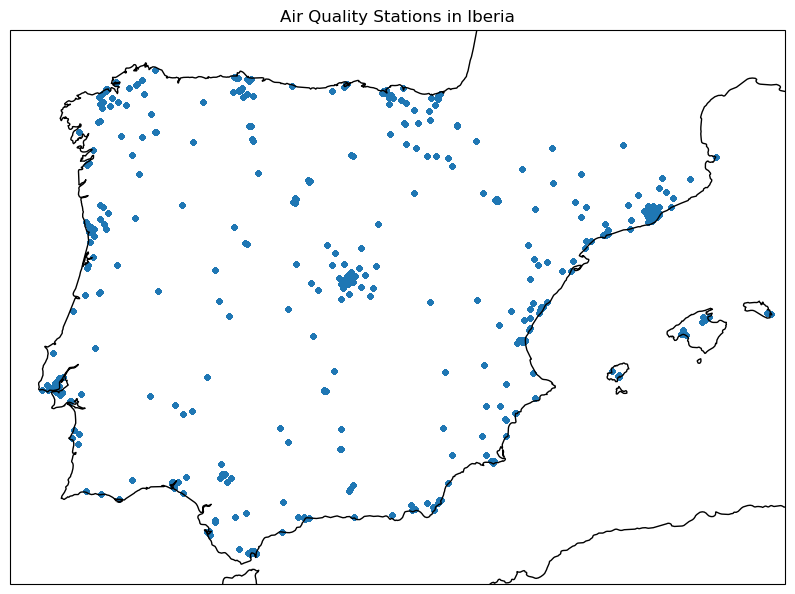

In [61]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
ax.scatter(observations.Longitude, observations.Latitude, transform=ccrs.PlateCarree(), s=10)
plt.title("Air Quality Stations in Iberia")
plt.show()

## 2.3. Define ROIs

In [62]:
from sklearn.cluster import DBSCAN

# Define the clustering model
dbscan = DBSCAN(eps=0.1, min_samples=5)

# Fit the model
clusters = dbscan.fit_predict(stations[['Longitude', 'Latitude']])
stations.loc[:, 'cluster'] = clusters
stations = stations[stations.cluster != -1]

stations

/tmp/ipykernel_1075496/2663937629.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations.loc[:, 'cluster'] = clusters


,Longitude,Latitude,cluster
station,,,
ES1044A,-0.8711,41.6703,0
ES1047A,-0.9161,41.6514,0
ES1641A,-0.8936,41.6353,0
ES1836A,-0.8619,41.6422,0
ES1837A,-0.8839,41.6483,0
...,...,...,...
PT01030,-8.6631,41.1861,15
PT01031,-8.6606,41.2522,15
PT01050,-8.6589,41.1475,15


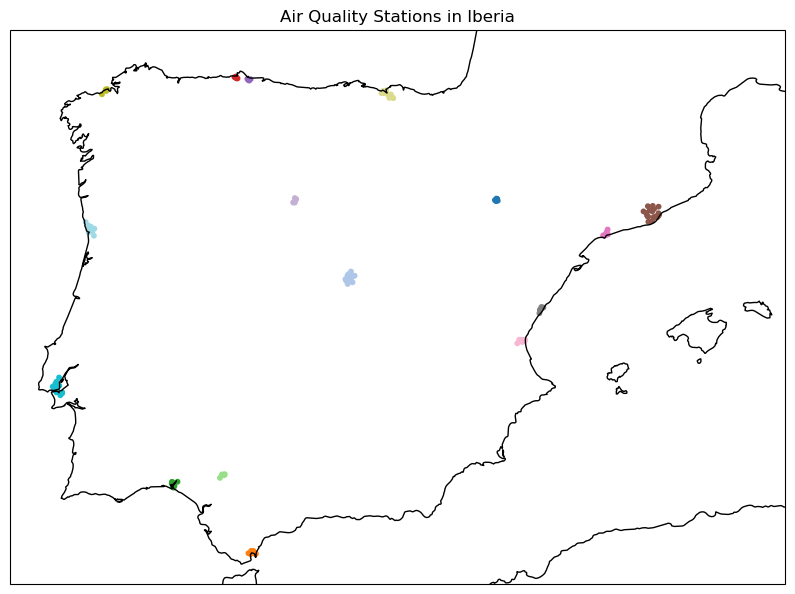

In [63]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([bbox["min_lon"], bbox["max_lon"], bbox["min_lat"], bbox["max_lat"]])
scatter = ax.scatter(stations.Longitude, stations.Latitude, transform=ccrs.PlateCarree(), s=10, c=stations.cluster, cmap='tab20')
plt.title("Air Quality Stations in Iberia")
plt.show()

In [64]:
region_box = stations.groupby('cluster').agg({'Latitude': ['min', 'max'], 'Longitude': ['min', 'max']})

region_box['n'] = stations.cluster.value_counts()
region_box['area (km²)'] = 111*(region_box['Latitude']['max'] - region_box['Latitude']['min']) * 111*(region_box['Longitude']['max'] - region_box['Longitude']['min'])
region_box['area (hm²)'] = region_box['area (km²)'] * 100
region_box['density (km²)'] = region_box['n'] / region_box['area (km²)']
region_box['density (hm²)'] = region_box['n'] / region_box['area (hm²)']

region_box

Latitude          Longitude           n  area (km²)    area (hm²)  \
             min      max       min     max                                 
cluster                                                                     
0        41.6353  41.6752   -0.9161 -0.8619   6   26.645148   2664.514818   
1        40.3469  40.5404   -3.7492 -3.5750  19  415.312572  41531.257170   
2        36.1594  36.2120   -5.4808 -5.3419   9   90.018951   9001.895094   
3        37.1903  37.2816   -6.9422 -6.8338   7  121.939951  12193.995132   
4        37.3408  37.3983   -6.0425 -5.9517   6   64.327941   6432.794100   
5        43.5503  43.5792   -5.9583 -5.8989   5   21.150968   2115.096786   
6        43.5166  43.5427   -5.7093 -5.6461   5   20.323736   2032.373592   
7        41.6128  41.6833   -4.7722 -4.7150   7   49.685665   4968.566460   
8        41.3135  41.5612    1.9232  2.2222  21  912.521598  91252.159830   
9        41.1024  41.1936    1.1496  1.2416   6  103.378118  10337.811840   
10       39.4253  39.4811   -0.4825 -0.3364   9  100.445474  10044.547398   
11       39.8922  39.9889   -0.0650  0.0106   5   90.072917   9007.291692   
12       43.3023  43.3828   -8.5060 -8.4092   5   96.010160   9601.016040   
13       43.2411  43.3621   -3.1127 -2.8837  11  341.402589  34140.258900   
14       38.6194  38.8947   -9.2308 -9.0478  15  620.730748  62073.074790   
15       41.0967  41.3086   -8.7208 -8.5528   9  438.617743  43861.774320   

        density (km²) density (hm²)  
                                     
cluster                              
0            0.225182      0.002252  
1            0.045749      0.000457  
2            0.099979      0.001000  
3            0.057405      0.000574  
4            0.093272      0.000933  
5            0.236396      0.002364  
6            0.246018      0.002460  
7            0.140886      0.001409  
8            0.023013      0.000230  
9            0.058039      0.000580  
10           0.089601      0.000896  
11           0.055511      0.000555  
12           0.052078      0.000521  
13           0.032220      0.000322  
14           0.024165      0.000242  
15           0.020519      0.000205

In [65]:
observations = observations.join(stations['cluster'], on='station', how='inner')

observations

NO2  Longitude  Latitude  cluster
time                station                                    
2022-01-01 00:00:00 ES0041A   9.0    -2.9457   43.2588       13
                    ES0118A  35.0    -3.6822   40.4217        1
                    ES0120A  26.0    -3.6772   40.4517        1
                    ES0124A  20.0    -3.6392   40.4400        1
                    ES0125A  64.0    -3.7050   40.3469        1
...                           ...        ...       ...      ...
2022-01-25 11:00:00 PT03087  19.0    -9.2103   38.7050       14
                    PT03095   9.8    -9.0669   38.6586       14
                    PT03097  24.2    -9.1822   38.8022       14
                    PT03100  36.7    -9.2025   38.7481       14
                    PT03103  16.2    -9.0486   38.6500       14

[1270345 rows x 4 columns]

## 2.1. Temporal Resampling

In [66]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def fill_missing_values(observations, variable):
    df = observations.copy()
    df['hour'] = df.index.get_level_values('time').hour
    df['dayofweek'] = df.index.get_level_values('time').dayofweek
    df['weekofyear'] = df.index.get_level_values('time').isocalendar().week.values
    df[f'last_observed_{variable}'] = df.groupby('station')[variable].shift(1).transform(lambda x: x.ffill())
    
    missing = df[df[variable].isnull()]
    df = df.dropna(subset=[variable])
    
    features = ['hour', 'dayofweek', 'weekofyear', 'Longitude', 'Latitude', f'last_observed_{variable}']
    target = variable
    
    X = df[features]
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = make_pipeline(StandardScaler(), HistGradientBoostingRegressor())
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    print(f'R² Score: {r2_score(y_test, y_pred)}')
    
    missing = missing.join(
        df.groupby(['station', 'hour', 'dayofweek'])[f'last_observed_{variable}'].mean(),
        on=['station', 'hour', 'dayofweek'],
        rsuffix='_mean')
    
    missing[f'last_observed_{variable}'] = missing[f'last_observed_{variable}'].fillna(missing[f'last_observed_{variable}_mean'])
    
    missing = missing.drop(columns=[f'last_observed_{variable}_mean'])
    
    # Predict the missing values
    missing[variable] = model.predict(missing[features])
    observations = pd.concat([df, missing])[[variable, 'Latitude', 'Longitude', 'cluster']]
    observations = observations.sort_index()
    
    return observations

observations = fill_missing_values(observations, variable=variable)

observations

R² Score: 0.8387994656840758


NO2  Latitude  Longitude  cluster
time       station                                    
2022-01-01 ES0041A   9.0   43.2588    -2.9457       13
           ES0118A  35.0   40.4217    -3.6822        1
           ES0120A  26.0   40.4517    -3.6772        1
           ES0124A  20.0   40.4400    -3.6392        1
           ES0125A  64.0   40.3469    -3.7050        1
...                  ...       ...        ...      ...
2023-01-01 PT03087   3.1   38.7050    -9.2103       14
           PT03095   4.8   38.6586    -9.0669       14
           PT03097   7.8   38.8022    -9.1822       14
           PT03100  12.6   38.7481    -9.2025       14
           PT03103   9.4   38.6500    -9.0486       14

[1270345 rows x 4 columns]

## 2.4. Generate permutations for each cluster

In [67]:
n=5

permutations = pd.get_dummies(
    observations.groupby(['time', 'cluster'], group_keys=False)
    .apply(lambda x: x.sample(n).assign(i=range(n)), include_groups=False)
    .get('i').astype(str).reindex(observations.index)
).add_prefix('perm_')

permutations

perm_0  perm_1  perm_2  perm_3  perm_4
time       station                                        
2022-01-01 ES0041A   False   False   False    True   False
           ES0118A    True   False   False   False   False
           ES0120A   False   False   False   False   False
           ES0124A   False   False   False   False   False
           ES0125A   False   False   False   False   False
...                    ...     ...     ...     ...     ...
2023-01-01 PT03087    True   False   False   False   False
           PT03095   False   False   False   False   False
           PT03097   False   False   False   False   False
           PT03100   False   False   False   False   False
           PT03103   False   False   False   False   False

[1270345 rows x 5 columns]

In [68]:
from scipy.spatial import KDTree

def interpolate_points(x, variable):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[['Latitude', 'Longitude', variable]].reset_index(drop=True)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    interpolated_results = []

    for mask_row in mask:
        points = all_points[~mask_row]
        obs = all_points[mask_row]

        tree = KDTree(points[:, :2])
        dist, idx = tree.query(obs[:, :2])
        
        interpolated_results.append(np.hstack([
            obs,
            points[idx][:, 2:3],
            dist[:, np.newaxis]]))
    
    # Combine all results into a single DataFrame
    return pd.DataFrame(
        np.vstack(interpolated_results),
        columns=['Latitude', 'Longitude', f'{variable}_obs', f'{variable}_interp', 'dist'])
    
# Apply the function to the dataset
dataset = observations.join(permutations).groupby(['time', 'cluster']).apply(interpolate_points, variable=variable)
dataset = dataset.reset_index().drop(columns=['level_2'])

dataset

/tmp/ipykernel_1075496/20304055.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = observations.join(permutations).groupby(['time', 'cluster']).apply(interpolate_points, variable=variable)


,time,cluster,Latitude,Longitude,NO2_obs,NO2_interp,dist
0,2022-01-01,0,41.6483,-0.8839,22.100000,21.620000,0.016220
1,2022-01-01,0,41.6703,-0.8711,19.410000,18.930000,0.016542
2,2022-01-01,0,41.6422,-0.8619,19.540000,22.100000,0.022830
3,2022-01-01,0,41.6353,-0.8936,21.620000,22.100000,0.016220
4,2022-01-01,0,41.6752,-0.8869,18.930000,19.410000,0.016542
...,...,...,...,...,...,...,...
700875,2023-01-01,15,41.2356,-8.6186,13.100000,3.447557,0.044385
700876,2023-01-01,15,41.3086,-8.7208,21.862566,21.837694,0.082492
700877,2023-01-01,15,41.0967,-8.5558,3.800000,24.400000,0.075579
700878,2023-01-01,15,41.1644,-8.5894,24.400000,9.800000,0.055936


# 3. Elevation

In [69]:
from cams_downscaling.readers.topography import load_topography

new_lat = np.arange(bbox["min_lat"], bbox["max_lat"], new_resolution)
new_lon = np.arange(bbox["min_lon"], bbox["max_lon"], new_resolution)

topography = load_topography("/data1/data_prep/nasa_topo/topo.tiff", bbox)
topography = topography.interpolate(lat=new_lat, lon=new_lon)

topography

GridData(
    > Axes:
        - lat: 840 elements
        - lon: 1440 elements
    > Data:
        - elevation: (840, 1440)
    > Memory: 9.23 MB
)

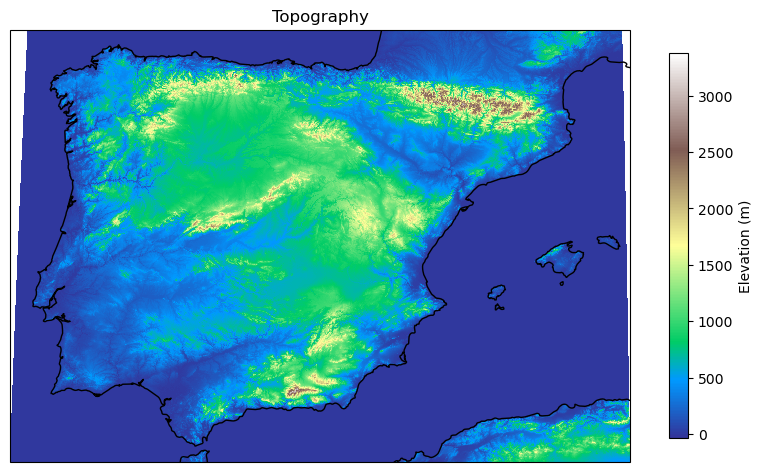

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

data = topography.values['elevation']

# Define the extent
extent = (topography.lon.min(), topography.lon.max(), topography.lat.min(), topography.lat.max())

# Create a meshgrid for the coordinates
lon, lat = np.meshgrid(topography.lon, topography.lat)

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Plot the data
im = ax.pcolormesh(lon, lat, data.squeeze(), cmap=plt.cm.terrain, transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('Elevation (m)')

# Set the title
plt.title('Topography')

# Show the plot
plt.show()


In [71]:
topography = pd.concat([
    load_topography(
        "/data1/data_prep/nasa_topo/topo.tiff",
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

topography

,elevation
station,
ES1044A,199.5500
ES1047A,223.1800
ES1641A,226.0000
ES1836A,199.1000
ES1837A,224.7908
...,...
PT01030,63.8000
PT01031,80.7068
PT01050,19.2596


## 3.X. Add external covariates

In [72]:
from cams_downscaling.readers.cams import load_cams

cams_path = config['paths']['cams']
cams_path = os.path.join(cams_path, variable.lower(), region)

dates = observations.index.get_level_values('time').unique()

cams = load_cams(cams_path, dates=dates)

cams =  cams.interpolate(
    lat=stations.sort_index()['Latitude'],
    lon=stations.sort_index()['Longitude'],
    grid=False).to_frame()

cams.index = observations.sort_index().index
cams.columns = [v.upper() for v in cams.columns]

cams

NO2
time       station           
2022-01-01 ES0041A   6.582984
           ES0118A  36.324727
           ES0120A  32.703560
           ES0124A  32.935106
           ES0125A  47.090803
...                       ...
2023-01-01 PT03087   6.654701
           PT03095   6.490344
           PT03097   7.477683
           PT03100   7.632195
           PT03103   6.426193

[1270345 rows x 1 columns]

In [73]:
from cams_downscaling.readers.era5 import load_era5

dates = observations.index.get_level_values('time').unique()

era5 = load_era5(config['paths']['era5'], dates)

era5 = era5.interpolate(
    lat=stations.sort_index()['Latitude'],
    lon=stations.sort_index()['Longitude'],
    grid=False).to_frame()

era5.index = observations.sort_index().index

era5

blh      iews      inss
time       station                                
2022-01-01 ES0041A  207.328486  0.351673  0.827367
           ES0118A   26.821882 -0.000652 -0.032933
           ES0120A   26.407590  0.001502 -0.034967
           ES0124A   26.991072 -0.002596 -0.031874
           ES0125A   27.743463 -0.005197 -0.028528
...                        ...       ...       ...
2023-01-01 PT03087  611.135776  0.004959  0.344164
           PT03095  562.320582 -0.011645  0.352027
           PT03097  621.040353  0.014089  0.391107
           PT03100  610.557583  0.009090  0.376839
           PT03103  555.962334 -0.014059  0.351143

[1270345 rows x 3 columns]

In [74]:
"""import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from scipy.spatial import KDTree
from joblib import Parallel, delayed

def kriging_interpolation(points, obs, kriging=True):
    lats = points[:, 0]
    lons = points[:, 1]
    Z = points[:, -1]

    # KDTree interpolation
    tree = KDTree(points[:, :2])
    dist, idx = tree.query(obs[:, :2])

    if kriging:
        # If all points are the same, return the same value for all observations
        if len(set(Z)) == 1:
            return np.hstack([
                obs,
                points[idx][:, -1:],
                points[idx][:, -1:],
                dist[:, np.newaxis],
                np.zeros((len(obs), 1))])

        # Define the Kriging model
        OK = OrdinaryKriging(
            lats, lons, Z,
            coordinates_type='geographic',
            verbose=False,
            enable_plotting=False)

        # Perform the interpolation
        interp_values, ss = OK.execute('points', obs[:, 0], obs[:, 1])

        return np.hstack([
            obs,
            points[idx][:, -1:],
            interp_values[:, np.newaxis],
            dist[:, np.newaxis],
            ss[:, np.newaxis]])
    
    return np.hstack([
        obs,
        points[idx][:, -1:],
        dist[:, np.newaxis]])

def interpolate_points(x, variable, kriging=True):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[[
        'Latitude', 'Longitude',
        'elevation', f'{variable}_cams',
        variable]].reset_index(drop=True)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    # Parallelize the interpolation process
    interpolated = Parallel(n_jobs=-1)(delayed(kriging_interpolation)(
        all_points[~mask_row], all_points[mask_row], kriging) for mask_row in mask)
    
    # Combine all results into a single DataFrame
    if kriging:
        return pd.DataFrame(
            np.vstack(interpolated),
            columns=[
                'Latitude', 'Longitude',
                'elevation', f'{variable}_cams',
                f'{variable}_obs', f'{variable}_kdtree', f'{variable}_kriging', 'dist', 'ss'])

    return pd.DataFrame(
        np.vstack(interpolated),
        columns=[
            'Latitude', 'Longitude',
            'elevation', f'{variable}_cams',
            f'{variable}_obs', f'{variable}_kdtree', 'dist'])

# Apply the function to the dataset
dataset = observations.join(topography)
dataset[f'{variable}_cams'] = cams[variable]

dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable.upper(),
    kriging=True).reset_index().drop(columns=['level_2'])

dataset"""

"import numpy as np\nimport pandas as pd\nfrom pykrige.ok import OrdinaryKriging\nfrom scipy.spatial import KDTree\nfrom joblib import Parallel, delayed\n\ndef kriging_interpolation(points, obs, kriging=True):\n    lats = points[:, 0]\n    lons = points[:, 1]\n    Z = points[:, -1]\n\n    # KDTree interpolation\n    tree = KDTree(points[:, :2])\n    dist, idx = tree.query(obs[:, :2])\n\n    if kriging:\n        # If all points are the same, return the same value for all observations\n        if len(set(Z)) == 1:\n            return np.hstack([\n                obs,\n                points[idx][:, -1:],\n                points[idx][:, -1:],\n                dist[:, np.newaxis],\n                np.zeros((len(obs), 1))])\n\n        # Define the Kriging model\n        OK = OrdinaryKriging(\n            lats, lons, Z,\n            coordinates_type='geographic',\n            verbose=False,\n            enable_plotting=False)\n\n        # Perform the interpolation\n        interp_values, ss 

In [75]:
from scipy.spatial import KDTree

def interpolate_points(x, variable):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[['Latitude', 'Longitude', 'elevation', f'{variable}_cams', variable]].reset_index(drop=True)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    interpolated_results = []

    for mask_row in mask:
        points = all_points[~mask_row]
        obs = all_points[mask_row]

        tree = KDTree(points[:, :2])
        dist, idx = tree.query(obs[:, :2])
        
        interpolated_results.append(np.hstack([
            obs,
            points[idx][:, -1:],
            dist[:, np.newaxis]]))
    
    # Combine all results into a single DataFrame
    return pd.DataFrame(
        np.vstack(interpolated_results),
        columns=[
            'Latitude', 'Longitude',
            'elevation', f'{variable}_cams',
            f'{variable}_obs', f'{variable}_interp', 'dist'])
    
# Apply the function to the dataset
dataset = observations.join(topography)
dataset[f'{variable}_cams'] = cams[variable]

dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable
).reset_index().drop(columns=['level_2'])

dataset

/tmp/ipykernel_1075496/901272225.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(


,time,cluster,Latitude,Longitude,elevation,NO2_cams,NO2_obs,NO2_interp,dist
0,2022-01-01,0,41.6483,-0.8839,224.7908,24.031480,22.100000,21.620000,0.016220
1,2022-01-01,0,41.6703,-0.8711,199.5500,22.981011,19.410000,18.930000,0.016542
2,2022-01-01,0,41.6422,-0.8619,199.1000,23.038702,19.540000,22.100000,0.022830
3,2022-01-01,0,41.6353,-0.8936,226.0000,23.134391,21.620000,22.100000,0.016220
4,2022-01-01,0,41.6752,-0.8869,202.9200,23.144955,18.930000,19.410000,0.016542
...,...,...,...,...,...,...,...,...,...
700875,2023-01-01,15,41.2356,-8.6186,90.5940,9.460221,13.100000,3.447557,0.044385
700876,2023-01-01,15,41.3086,-8.7208,39.0000,6.141968,21.862566,21.837694,0.082492
700877,2023-01-01,15,41.0967,-8.5558,71.5000,6.547801,3.800000,24.400000,0.075579
700878,2023-01-01,15,41.1644,-8.5894,145.3140,7.871199,24.400000,9.800000,0.055936


In [76]:
((dataset['NO2_cams'] - dataset['NO2_obs'])**2).mean()**0.5

14.643528501879034

In [77]:
((dataset['NO2_interp'] - dataset['NO2_obs'])**2).mean()**0.5

14.163571195000024

In [78]:
"""import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from scipy.spatial import KDTree
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression

def kriging_interpolation(points, obs, kriging=True):
    lats = points[:, 0]
    lons = points[:, 1]
    elev = points[:, 2]
    Z = points[:, 3]

    # Perform linear regression on elevation
    reg = LinearRegression().fit(elev.reshape(-1, 1), Z)
    trend = reg.predict(elev.reshape(-1, 1))
    residuals = Z - trend

    # KDTree interpolation
    tree = KDTree(points[:, :3])
    dist, idx = tree.query(obs[:, :3])

    if kriging:
        # If all points are the same, return the same value for all observations
        if len(set(Z)) == 1:
            return np.hstack([
                obs,
                points[idx][:, 3:4],
                points[idx][:, 3:4],
                dist[:, np.newaxis],
                np.zeros((len(obs), 1))])

        # Define the Kriging model using residuals
        OK = OrdinaryKriging(
            lats, lons, residuals,
            variogram_model='linear',
            verbose=False,
            enable_plotting=False)

        # Perform the interpolation of residuals
        residual_interp_values, ss = OK.execute('points', obs[:, 0], obs[:, 1])
        
        # Add the regression trend to the interpolated residuals
        obs_elev = obs[:, 2]
        obs_trend = reg.predict(obs_elev.reshape(-1, 1))
        interp_values = residual_interp_values + obs_trend

        return np.hstack([
            obs,
            points[idx][:, 3:4],
            interp_values[:, np.newaxis],
            dist[:, np.newaxis],
            ss[:, np.newaxis]])
    
    return np.hstack([
        obs,
        points[idx][:, 3:4],
        dist[:, np.newaxis]])

def interpolate_points(x, variable, kriging=True):
    perm = x.filter(like='perm_').reset_index(drop=True)
    x = x[['Latitude', 'Longitude', 'elevation', variable]].reset_index(drop=True)
    
    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    # Parallelize the interpolation process
    interpolated = Parallel(n_jobs=-1)(delayed(kriging_interpolation)(
        all_points[~mask_row], all_points[mask_row], kriging) for mask_row in mask)
    
    # Combine all results into a single DataFrame
    if kriging:
        return pd.DataFrame(
            np.vstack(interpolated),
            columns=['Latitude', 'Longitude', 'Elevation', f'{variable}_obs', f'{variable}_kdtree', f'{variable}_kriging', 'dist', 'ss'])

    return pd.DataFrame(
        np.vstack(interpolated),
        columns=['Latitude', 'Longitude', 'Elevation', f'{variable}_obs', f'{variable}_kdtree', 'dist'])

# Apply the function to the dataset
dataset = observations.join(topography)
dataset[f'{variable}_cams'] = cams[variable]

dataset = dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable.upper(),
    kriging=True).reset_index().drop(columns=['level_2'])

dataset"""

"import numpy as np\nimport pandas as pd\nfrom pykrige.ok import OrdinaryKriging\nfrom scipy.spatial import KDTree\nfrom joblib import Parallel, delayed\nfrom sklearn.linear_model import LinearRegression\n\ndef kriging_interpolation(points, obs, kriging=True):\n    lats = points[:, 0]\n    lons = points[:, 1]\n    elev = points[:, 2]\n    Z = points[:, 3]\n\n    # Perform linear regression on elevation\n    reg = LinearRegression().fit(elev.reshape(-1, 1), Z)\n    trend = reg.predict(elev.reshape(-1, 1))\n    residuals = Z - trend\n\n    # KDTree interpolation\n    tree = KDTree(points[:, :3])\n    dist, idx = tree.query(obs[:, :3])\n\n    if kriging:\n        # If all points are the same, return the same value for all observations\n        if len(set(Z)) == 1:\n            return np.hstack([\n                obs,\n                points[idx][:, 3:4],\n                points[idx][:, 3:4],\n                dist[:, np.newaxis],\n                np.zeros((len(obs), 1))])\n\n        # Defi

In [79]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
data = dataset.copy()

# Feature engineering: Create new features (examples)
data['hour'] = pd.to_datetime(data['time']).dt.hour
data['day'] = pd.to_datetime(data['time']).dt.day
data['month'] = pd.to_datetime(data['time']).dt.month
data['year'] = pd.to_datetime(data['time']).dt.year

# Define the features (X) and the target (y)
features = ['cluster', 'Latitude', 'Longitude', 'elevation', 'NO2_cams', 'NO2_interp', 'dist', 'hour', 'day', 'month', 'year']
#features = ['cluster', 'Latitude', 'Longitude', 'elevation', 'NO2_cams', 'NO2_kdtree', 'NO2_kriging', 'dist', 'ss', 'hour', 'day', 'month', 'year']
X = data[features]
y = data['NO2_obs']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {mse**0.5}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 8.986515858088325
R² Score: 0.6899564687285744


In [80]:
from cams_downscaling.readers.topography import load_topography

topography = pd.concat([
    load_topography(
        config['paths']['topography'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

topography

,elevation
station,
ES1044A,199.5500
ES1047A,223.1800
ES1641A,226.0000
ES1836A,199.1000
ES1837A,224.7908
...,...
PT01030,63.8000
PT01031,80.7068
PT01050,19.2596


In [81]:
from cams_downscaling.readers.land_cover import load_corine

land_use = pd.concat([
    load_corine(
        config['paths']['land_cover'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate_discrete(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

land_use

,land
station,
ES1044A,3
ES1047A,1
ES1641A,1
ES1836A,1
ES1837A,1
...,...
PT01030,3
PT01031,1
PT01050,1


In [82]:
from cams_downscaling.readers.population import load_pop

population = pd.concat([
    load_pop(
        config['paths']['population'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

population

,population
station,
ES1044A,68.524971
ES1047A,414.279801
ES1641A,274.406996
ES1836A,42.816579
ES1837A,338.890278
...,...
PT01030,28.987929
PT01031,21.178273
PT01050,0.000000


In [83]:
from cams_downscaling.readers.build_height import load_height

height = pd.concat([
    load_height(
        config['paths']['height'],
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

height

,height
station,
ES1044A,5.511122
ES1047A,12.017872
ES1641A,7.956979
ES1836A,3.386316
ES1837A,10.100728
...,...
PT01030,3.797879
PT01031,0.937323
PT01050,0.001625


In [84]:
from cams_downscaling.readers.era5_land import load_era5_land

dates = observations.index.get_level_values('time').unique()

era5_land = load_era5_land(config['paths']['era5_land'], dates)

era5_land = era5_land.interpolate(
    lat=stations.sort_index()['Latitude'],
    lon=stations.sort_index()['Longitude'],
    grid=False).to_frame()

era5_land.index = observations.sort_index().index

era5_land

d2m           ssr         t2m            tp  \
time       station                                                       
2022-01-01 ES0041A  277.954137  6.840293e+06  285.564258  8.523463e-07   
           ES0118A  274.928943  7.888376e+06  276.669682  8.523463e-07   
           ES0120A  274.706043  7.889477e+06  276.510501  8.523463e-07   
           ES0124A  274.879401  7.853082e+06  276.605304  8.523463e-07   
           ES0125A  275.117791  7.796199e+06  276.573844  9.639135e-07   
...                        ...           ...         ...           ...   
2023-01-01 PT03087    0.000000  0.000000e+00    0.000000  0.000000e+00   
           PT03095    0.000000  0.000000e+00    0.000000  0.000000e+00   
           PT03097    0.000000  0.000000e+00    0.000000  0.000000e+00   
           PT03100    0.000000  0.000000e+00    0.000000  0.000000e+00   
           PT03103    0.000000  0.000000e+00    0.000000  0.000000e+00   

                         v10       u10  
time       station                      
2022-01-01 ES0041A  5.076528  0.709378  
           ES0118A -1.394990 -0.622067  
           ES0120A -1.528286 -0.417866  
           ES0124A -1.370668 -0.617615  
           ES0125A -1.113840 -0.998697  
...                      ...       ...  
2023-01-01 PT03087  0.000000  0.000000  
           PT03095  0.000000  0.000000  
           PT03097  0.000000  0.000000  
           PT03100  0.000000  0.000000  
           PT03103  0.000000  0.000000  

[1270345 rows x 6 columns]

In [85]:
from cams_downscaling.readers.roads import load_osm

roads = pd.concat([
    load_osm(
        f"{config['paths']['osm']}/iberia.tif",
        {k: v for k, v in zip(['min_lat', 'max_lat', 'min_lon', 'max_lon'], region_box.loc[c][['Latitude', 'Longitude']].values)})
    .interpolate_discrete(
        lat=stations[stations.cluster == c]['Latitude'],
        lon=stations[stations.cluster == c]['Longitude'],
        grid=False).to_frame().set_index(stations[stations.cluster == c].index)
    for c in stations.cluster.unique()])

roads

,roads
station,
ES1044A,0.0
ES1047A,4.0
ES1641A,5.0
ES1836A,5.0
ES1837A,3.0
...,...
PT01030,1.0
PT01031,6.0
PT01050,0.0


# Model

He preparat aquesta part perque pogueu fer proves incorporant diferents datasets.

Em sembla que no cambiara gaire, pero bueno.

Simplement correu a partir de aquesta cel·la i només heu de modificar la cel·la de sota segons les dades que volgueu incorporar.

Per guardar-ho a sql no tinc clar com fer-ho, però els resultats del model estan a la ultima cel·la.

In [86]:
# Apply the function to the dataset
dataset = (
    observations
    .join(topography)
    .join(land_use)
    .join(era5)
    .join(era5_land)
    .join(population)
    .join(height)
    # .join(roads)
)
model_version = 107

dataset

NO2  Latitude  Longitude  cluster  elevation  land  \
time       station                                                        
2022-01-01 ES0041A   9.0   43.2588    -2.9457       13    38.2800     1   
           ES0118A  35.0   40.4217    -3.6822        1   682.1480     1   
           ES0120A  26.0   40.4517    -3.6772        1   723.8920     1   
           ES0124A  20.0   40.4400    -3.6392        1   698.5200     2   
           ES0125A  64.0   40.3469    -3.7050        1   599.0000     1   
...                  ...       ...        ...      ...        ...   ...   
2023-01-01 PT03087   3.1   38.7050    -9.2103       14    83.7000     2   
           PT03095   4.8   38.6586    -9.0669       14    18.9496     1   
           PT03097   7.8   38.8022    -9.1822       14   122.2700     2   
           PT03100  12.6   38.7481    -9.2025       14    92.8724     1   
           PT03103   9.4   38.6500    -9.0486       14    39.7372     1   

                           blh      iews      inss         d2m           ssr  \
time       station                                                             
2022-01-01 ES0041A  207.328486  0.351673  0.827367  277.954137  6.840293e+06   
           ES0118A   26.821882 -0.000652 -0.032933  274.928943  7.888376e+06   
           ES0120A   26.407590  0.001502 -0.034967  274.706043  7.889477e+06   
           ES0124A   26.991072 -0.002596 -0.031874  274.879401  7.853082e+06   
           ES0125A   27.743463 -0.005197 -0.028528  275.117791  7.796199e+06   
...                        ...       ...       ...         ...           ...   
2023-01-01 PT03087  611.135776  0.004959  0.344164    0.000000  0.000000e+00   
           PT03095  562.320582 -0.011645  0.352027    0.000000  0.000000e+00   
           PT03097  621.040353  0.014089  0.391107    0.000000  0.000000e+00   
           PT03100  610.557583  0.009090  0.376839    0.000000  0.000000e+00   
           PT03103  555.962334 -0.014059  0.351143    0.000000  0.000000e+00   

                           t2m            tp       v10       u10  population  \
time       station                                                             
2022-01-01 ES0041A  285.564258  8.523463e-07  5.076528  0.709378  558.060450   
           ES0118A  276.669682  8.523463e-07 -1.394990 -0.622067  210.409996   
           ES0120A  276.510501  8.523463e-07 -1.528286 -0.417866  113.033880   
           ES0124A  276.605304  8.523463e-07 -1.370668 -0.617615  225.282948   
           ES0125A  276.573844  9.639135e-07 -1.113840 -0.998697   33.081624   
...                        ...           ...       ...       ...         ...   
2023-01-01 PT03087    0.000000  0.000000e+00  0.000000  0.000000  317.518708   
           PT03095    0.000000  0.000000e+00  0.000000  0.000000  176.097896   
           PT03097    0.000000  0.000000e+00  0.000000  0.000000    0.000000   
           PT03100    0.000000  0.000000e+00  0.000000  0.000000  135.793639   
           PT03103    0.000000  0.000000e+00  0.000000  0.000000    0.008827   

                       height  
time       station             
2022-01-01 ES0041A  10.744770  
           ES0118A   4.692806  
           ES0120A   2.363004  
           ES0124A   4.312278  
           ES0125A   4.953482  
...                       ...  
2023-01-01 PT03087   4.904937  
           PT03095   4.142632  
           PT03097   0.000000  
           PT03100   8.681353  
           PT03103   0.000693  

[1270345 rows x 17 columns]

In [87]:
from sklearn.model_selection import train_test_split

pairs = dataset.reset_index()[['time', 'cluster']]
pairs['time'] = pairs['time'].dt.date

train_split, test_split = train_test_split(pairs.drop_duplicates(), test_size=0.1, random_state=42)

train_set = set(train_split.itertuples(index=False, name=None))
test_set = set(test_split.itertuples(index=False, name=None))

train_dataset = dataset[[t in train_set for t in zip(dataset.index.get_level_values('time').date, dataset.cluster)]].copy()
test_dataset = dataset[[t in test_set for t in zip(dataset.index.get_level_values('time').date, dataset.cluster)]].copy()

In [88]:
dataset

NO2  Latitude  Longitude  cluster  elevation  land  \
time       station                                                        
2022-01-01 ES0041A   9.0   43.2588    -2.9457       13    38.2800     1   
           ES0118A  35.0   40.4217    -3.6822        1   682.1480     1   
           ES0120A  26.0   40.4517    -3.6772        1   723.8920     1   
           ES0124A  20.0   40.4400    -3.6392        1   698.5200     2   
           ES0125A  64.0   40.3469    -3.7050        1   599.0000     1   
...                  ...       ...        ...      ...        ...   ...   
2023-01-01 PT03087   3.1   38.7050    -9.2103       14    83.7000     2   
           PT03095   4.8   38.6586    -9.0669       14    18.9496     1   
           PT03097   7.8   38.8022    -9.1822       14   122.2700     2   
           PT03100  12.6   38.7481    -9.2025       14    92.8724     1   
           PT03103   9.4   38.6500    -9.0486       14    39.7372     1   

                           blh      iews      inss         d2m           ssr  \
time       station                                                             
2022-01-01 ES0041A  207.328486  0.351673  0.827367  277.954137  6.840293e+06   
           ES0118A   26.821882 -0.000652 -0.032933  274.928943  7.888376e+06   
           ES0120A   26.407590  0.001502 -0.034967  274.706043  7.889477e+06   
           ES0124A   26.991072 -0.002596 -0.031874  274.879401  7.853082e+06   
           ES0125A   27.743463 -0.005197 -0.028528  275.117791  7.796199e+06   
...                        ...       ...       ...         ...           ...   
2023-01-01 PT03087  611.135776  0.004959  0.344164    0.000000  0.000000e+00   
           PT03095  562.320582 -0.011645  0.352027    0.000000  0.000000e+00   
           PT03097  621.040353  0.014089  0.391107    0.000000  0.000000e+00   
           PT03100  610.557583  0.009090  0.376839    0.000000  0.000000e+00   
           PT03103  555.962334 -0.014059  0.351143    0.000000  0.000000e+00   

                           t2m            tp       v10       u10  population  \
time       station                                                             
2022-01-01 ES0041A  285.564258  8.523463e-07  5.076528  0.709378  558.060450   
           ES0118A  276.669682  8.523463e-07 -1.394990 -0.622067  210.409996   
           ES0120A  276.510501  8.523463e-07 -1.528286 -0.417866  113.033880   
           ES0124A  276.605304  8.523463e-07 -1.370668 -0.617615  225.282948   
           ES0125A  276.573844  9.639135e-07 -1.113840 -0.998697   33.081624   
...                        ...           ...       ...       ...         ...   
2023-01-01 PT03087    0.000000  0.000000e+00  0.000000  0.000000  317.518708   
           PT03095    0.000000  0.000000e+00  0.000000  0.000000  176.097896   
           PT03097    0.000000  0.000000e+00  0.000000  0.000000    0.000000   
           PT03100    0.000000  0.000000e+00  0.000000  0.000000  135.793639   
           PT03103    0.000000  0.000000e+00  0.000000  0.000000    0.008827   

                       height  
time       station             
2022-01-01 ES0041A  10.744770  
           ES0118A   4.692806  
           ES0120A   2.363004  
           ES0124A   4.312278  
           ES0125A   4.953482  
...                       ...  
2023-01-01 PT03087   4.904937  
           PT03095   4.142632  
           PT03097   0.000000  
           PT03100   8.681353  
           PT03103   0.000693  

[1270345 rows x 17 columns]

In [89]:
permutations = pd.get_dummies(
    observations.groupby([observations.index.get_level_values('time').date, 'cluster'], group_keys=False)
    .apply(lambda x: x.sample(n).assign(i=range(n)), include_groups=False)
    .get('i').astype(str).reindex(observations.index)
    .groupby([observations.index.get_level_values('time').date, 'station'], group_keys=False)
    .apply(lambda x: x.ffill().bfill())
).add_prefix('perm_')

permutations

/tmp/ipykernel_1075496/3054760628.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .apply(lambda x: x.ffill().bfill())


perm_0  perm_1  perm_2  perm_3  perm_4
time       station                                        
2022-01-01 ES0041A   False   False   False   False   False
           ES0118A   False   False    True   False   False
           ES0120A   False   False   False   False    True
           ES0124A   False   False   False   False   False
           ES0125A   False   False   False   False   False
...                    ...     ...     ...     ...     ...
2023-01-01 PT03087   False   False   False   False   False
           PT03095   False   False   False   False   False
           PT03097    True   False   False   False   False
           PT03100   False    True   False   False   False
           PT03103   False   False   False   False   False

[1270345 rows x 5 columns]

In [90]:
external_variables = dataset.columns[4:].tolist()

external_variables

['elevation',
 'land',
 'blh',
 'iews',
 'inss',
 'd2m',
 'ssr',
 't2m',
 'tp',
 'v10',
 'u10',
 'population',
 'height']

In [91]:
from scipy.spatial import KDTree

def interpolate_points(x, variable):
    perm = x.filter(like='perm_').reset_index(drop=True)
    station = x.index.get_level_values('station')
    x = x[[
        'Latitude', 'Longitude']
        + external_variables +
        [f'{variable}_cams', variable]].reset_index(drop=True)
    x.insert(2, 'station', station)

    # Separate points and observations
    mask = perm.values.T
    all_points = x.values
    
    interpolated_results = []

    for mask_row in mask:
        points = all_points[~mask_row]
        obs = all_points[mask_row]

        tree = KDTree(points[:, :2])
        dist, idx = tree.query(obs[:, :2])
        
        interpolated_results.append(np.hstack([
            obs,
            points[idx][:, -1:],
            dist[:, np.newaxis]]))
    
    # Combine all results into a single DataFrame
    return pd.DataFrame(
        np.vstack(interpolated_results),
        columns=[
            'Latitude', 'Longitude', 'station']
            + external_variables +
            [f'{variable}_cams',
            f'{variable}_obs', f'{variable}_interp', 'dist'])

train_dataset[f'{variable}_cams'] = cams[variable]
train_dataset = train_dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable
).reset_index().drop(columns=['level_2'])

test_dataset[f'{variable}_cams'] = cams[variable]
test_dataset = test_dataset.join(permutations).groupby(['time', 'cluster']).apply(
    interpolate_points,
    variable=variable
).reset_index().drop(columns=['level_2'])

train_dataset

/tmp/ipykernel_1075496/1860317773.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_dataset = train_dataset.join(permutations).groupby(['time', 'cluster']).apply(
/tmp/ipykernel_1075496/1860317773.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_dataset = test_dataset.join(permutations).groupby(['time', 'cluster']).apply(


,time,cluster,Latitude,Longitude,station,elevation,land,blh,iews,inss,...,t2m,tp,v10,u10,population,height,NO2_cams,NO2_obs,NO2_interp,dist
0,2022-01-01,0,41.6483,-0.8839,ES1837A,224.7908,1,22.170534,0.002241,0.028155,...,277.257134,0.000013,1.627047,-0.363662,338.890278,10.100728,24.03148,22.1,21.62,0.01622
1,2022-01-01,0,41.6752,-0.8869,ES2089A,202.92,1,22.059342,-0.000712,0.024023,...,277.312358,0.000013,1.53755,-0.429117,319.046964,9.725286,23.144955,18.93,19.41,0.016542
2,2022-01-01,0,41.6703,-0.8711,ES1044A,199.55,3,21.864168,-0.001095,0.023434,...,277.2978,0.000014,1.545924,-0.475952,68.524971,5.511122,22.981011,19.41,18.93,0.016542
3,2022-01-01,0,41.6422,-0.8619,ES1836A,199.1,1,21.743999,0.001405,0.026527,...,277.292181,0.000014,1.621769,-0.422312,42.816579,3.386316,23.038702,19.54,22.1,0.02283
4,2022-01-01,1,40.3981,-3.6867,ES1937A,607.9,2,27.141574,-0.002302,-0.031373,...,276.786004,0.000001,-1.292209,-0.777566,162.24306,3.081919,39.369754,40.0,35.0,0.024025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488254,2023-01-01,15,41.3086,-8.7208,PT01051,39.0,25,452.8992,0.043321,0.153413,...,0.0,0.0,0.0,0.0,0.002921,0.000557,6.141968,21.862566,21.837694,0.082492
488255,2023-01-01,15,41.1475,-8.6589,PT01050,19.2596,1,564.807099,0.062518,0.320112,...,0.0,0.0,0.0,0.0,0.0,0.001625,7.936672,15.6,24.7,0.038828
488256,2023-01-01,15,41.0967,-8.5558,PT01053,71.5,2,606.56249,0.099123,0.561742,...,0.0,0.0,0.0,0.0,4.341052,0.766067,6.547801,3.8,24.4,0.075579
488257,2023-01-01,15,41.1644,-8.5894,PT01028,145.314,1,581.606196,0.082613,0.397795,...,0.0,0.0,0.0,0.0,11.04599,4.540518,7.871199,24.4,9.8,0.055936


In [92]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

def prepare_dataset(data):
    data['hour'] = pd.to_datetime(data['time']).dt.hour
    data['day'] = pd.to_datetime(data['time']).dt.day
    data['month'] = pd.to_datetime(data['time']).dt.month
    data['year'] = pd.to_datetime(data['time']).dt.year

    features = [
        'cluster', 'Latitude', 'Longitude'] + external_variables + [
        'NO2_cams', 'NO2_interp', 'dist', 'hour', 'day', 'month', 'year']

    X = data[features]
    y = data['NO2_obs']

    return X, y

X_train, y_train = prepare_dataset(train_dataset)
X_test, y_test = prepare_dataset(test_dataset)

# Initialize and train the model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error: {mse**0.5}')
print(f'R² Score: {r2}')

Root Mean Squared Error: 8.854246533054212
R² Score: 0.7218666057221216


In [93]:
from cams_downscaling.datatypes import DatabaseTSPD

stations=test_dataset.station
date=test_dataset.time
points=test_dataset[['Latitude', 'Longitude']]
values=y_pred

db = DatabaseTSPD(stations, date, points, values)
db.values

model_version=99999
db.save_sql(model_version=model_version, drop_previous=True)

In [94]:
version_tracker = {
    '100': ['elevation',
        'land'],
    '101': ['elevation',
        'land',
        'blh',
        'iews',
        'inss',
        'd2m',
        'ssr',
        't2m',
        'tp',
        'v10',
        'u10'],
    '102': ['elevation',
        'land',
        'population'],
    '103': ['elevation',
        'land',
        'height'],
    '104': ['elevation',
        'land',
        'blh',
        'iews',
        'inss',
        'd2m',
        'ssr',
        't2m',
        'tp',
        'v10',
        'u10',
        'population',
        'height'],
    '105': [],
    '106': ['elevation'],
    '107': ['land']
}